# NETFLIX DATA DRIVEN PRODUCT RECCOMENDATION





As an integration to the original code and to expand the analysis on the basis of what we discussed during the presentation we have implemented a Reccomender System where given a movie and based on the features of the movie such as actor, director, country, listed_In we reccomend a list of related movies and we visualize the relationships in a graph format.

### Import Packages

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
%%capture
!pip install pandas_profiling
!pip install pydantic-settings
!pip install bump-pydantic
!pip install -U pydantic
!pip install AutoViz
!pip install hdbscan
!pip install --upgrade tensorflow

In [30]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math as math
from autoviz.AutoViz_Class import AutoViz_Class
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, hamming_loss, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.multiclass import OneVsRestClassifier
from hdbscan import HDBSCAN
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score, StratifiedKFold
import nltk
from nltk.stem.porter import PorterStemmer
import spacy
from scipy.sparse import csr_matrix
nlp = spacy.load('en_core_web_sm')
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
%matplotlib inline

### Import Dataset

In [85]:
df = pd.read_csv('netflix_titles.csv')

### Preprocess the data

Shape of your Data Set loaded: (8807, 12)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  0
    Number of Integer-Categorical Columns =  0
    Number of String-Categorical Columns =  1
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  1
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  3
    Number of NLP String Columns =  5
    Number of Date Time Columns =  1
    Number of ID Columns =  1
    Number of Columns to Delete =  0
    12 Predictors classified...
        1 variable(s) removed since they were ID or low-information variables
        List of variables removed: ['show_id']
To fix these data quality issues in the dataset, import 

Could not draw Distribution Plot


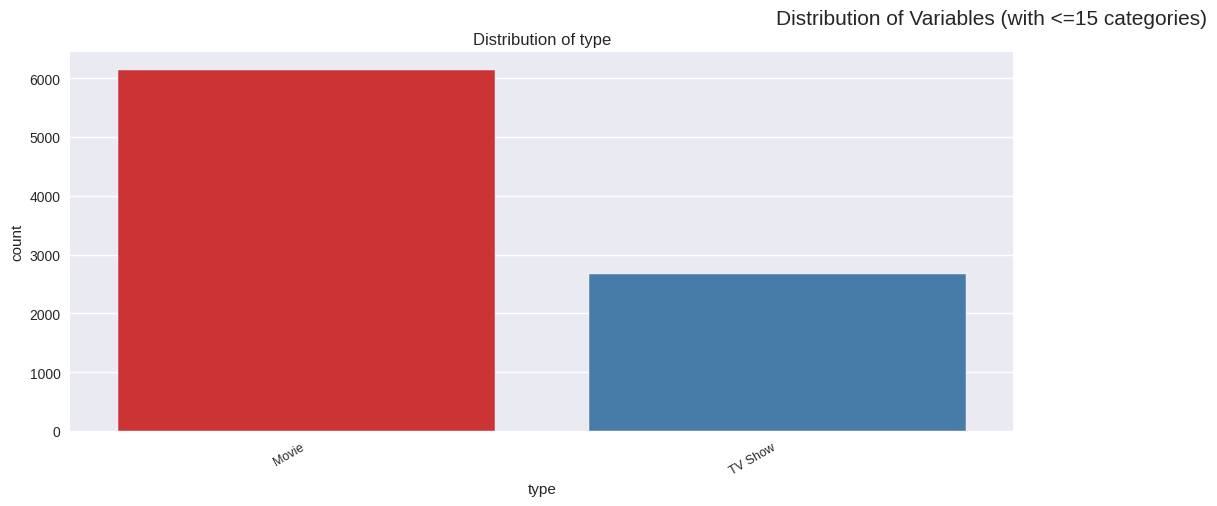

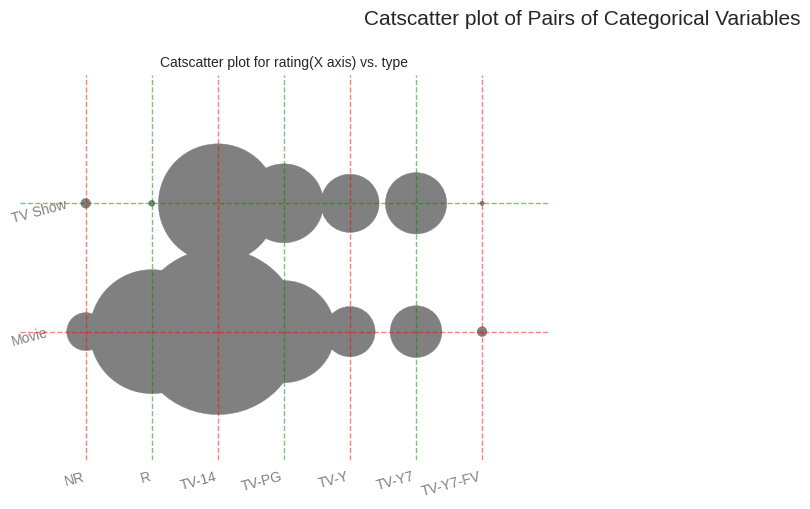

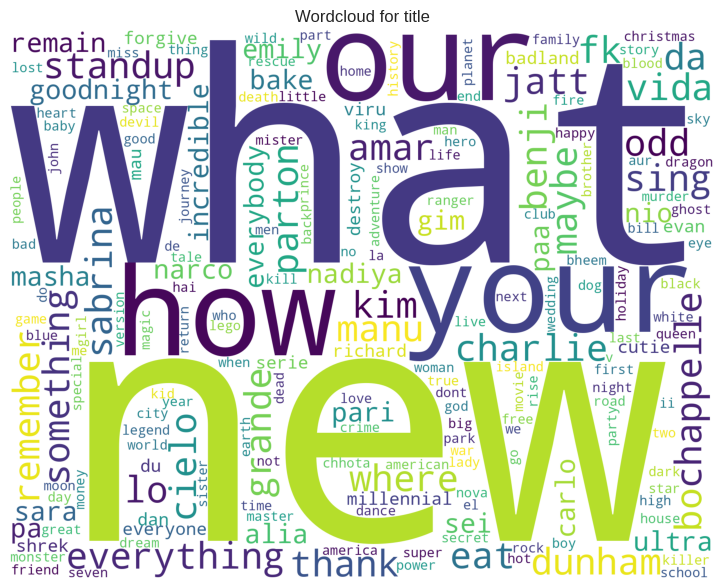

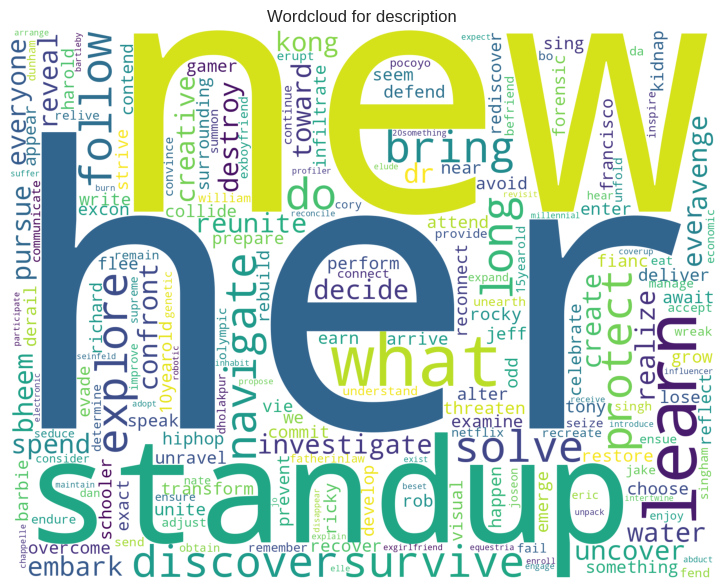

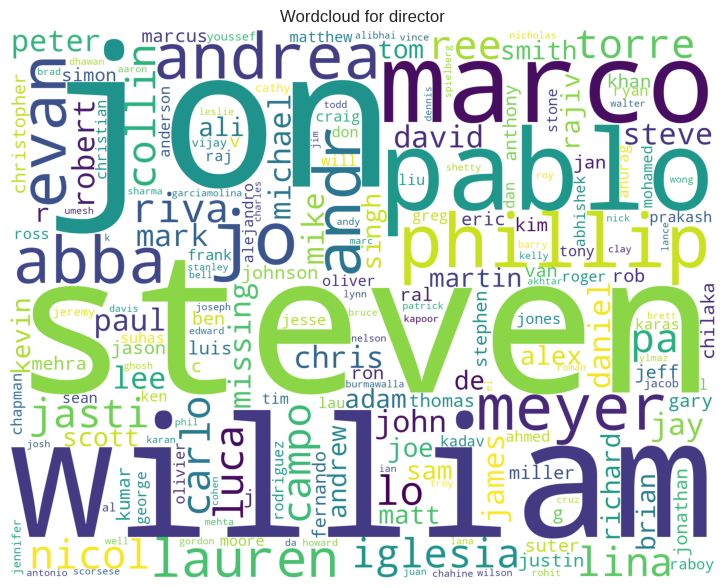

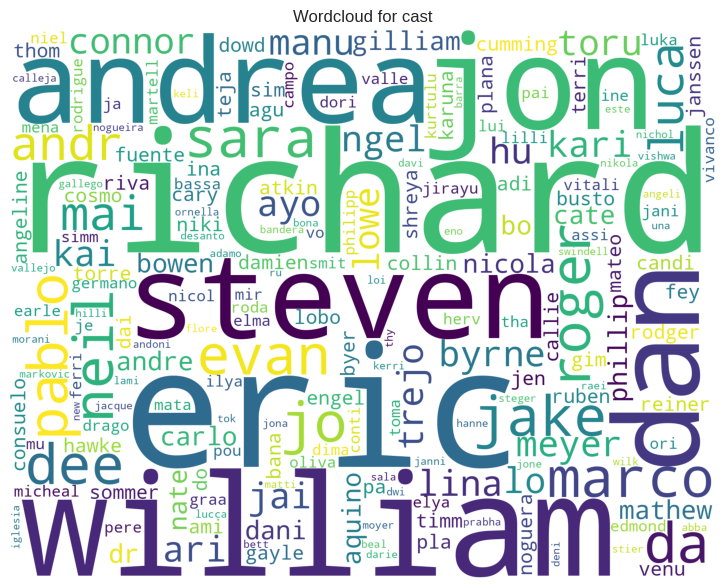

All Plots done
Time to run AutoViz = 75 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


In [72]:
autoviz = AutoViz_Class().AutoViz('netflix_titles.csv')

In [86]:
df.shape

(8807, 12)

In [87]:
df.head()

show_id   type           title              director      \
0    s1      Movie   Dick Johnson Is Dead  Kirsten Johnson   
1    s2    TV Show          Blood & Water              NaN   
2    s3    TV Show              Ganglands  Julien Leclercq   
3    s4    TV Show  Jailbirds New Orleans              NaN   
4    s5    TV Show           Kota Factory              NaN   

                                                                                                                                                        cast                                                                                                                                                        \
0                                                                                                                                                                                                                                                                                                              NaN   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng   
2                                                                                                                                                              Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera   
3                                                                                                                                                                                                                                                                                                              NaN   
4                                                                                                                                                                                                         Mayur More, Jitendra Kumar, Ranjan Raj, Alam Khan, Ahsaas Channa, Revathi Pillai, Urvi Singh, Arun Kumar   

     country          date_added      release_year rating  duration   \
0  United States  September 25, 2021      2020      PG-13     90 min   
1   South Africa  September 24, 2021      2021      TV-MA  2 Seasons   
2            NaN  September 24, 2021      2021      TV-MA   1 Season   
3            NaN  September 24, 2021      2021      TV-MA   1 Season   
4          India  September 24, 2021      2021      TV-MA  2 Seasons   

                            listed_in                             \
0                                                  Documentaries   
1                International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Action & Adventure   
3                                         Docuseries, Reality TV   
4         International TV Shows, Romantic TV Shows, TV Comedies   

                                                                         description                                                                         
0  As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.  
1       After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth.  
2        To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war.  
3       Feuds, flirtations and toilet talk go down among the incarcerated women at the Orleans Justice Center in New Orleans on this gritty reality series.  
4  In a city of coaching centers known to train India’s finest collegiate minds, an earnest but unexceptional student and his friends na

In [88]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


#### Kmeans Clustering with TF-IDF Weights

In [92]:
#We use KMeans clustering with TF-IDF weights

# import librairies
import networkx as nx
import math as math
import time
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]


In [93]:
# convert to datetime
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day
# convert columns "director, listed_in, cast and country" in columns that contain a real list
# the strip function is applied on the elements
# if the value is NaN, the new column contains a empty list []
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

df.head()


show_id   type           title              director      \
0    s1      Movie   Dick Johnson Is Dead  Kirsten Johnson   
1    s2    TV Show          Blood & Water              NaN   
2    s3    TV Show              Ganglands  Julien Leclercq   
3    s4    TV Show  Jailbirds New Orleans              NaN   
4    s5    TV Show           Kota Factory              NaN   

                                                                                                                                                        cast                                                                                                                                                        \
0                                                                                                                                                                                                                                                                                                              NaN   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng   
2                                                                                                                                                              Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera   
3                                                                                                                                                                                                                                                                                                              NaN   
4                                                                                                                                                                                                         Mayur More, Jitendra Kumar, Ranjan Raj, Alam Khan, Ahsaas Channa, Revathi Pillai, Urvi Singh, Arun Kumar   

     country     date_added  release_year rating  duration   \
0  United States 2021-09-25      2020      PG-13     90 min   
1   South Africa 2021-09-24      2021      TV-MA  2 Seasons   
2            NaN 2021-09-24      2021      TV-MA   1 Season   
3            NaN 2021-09-24      2021      TV-MA   1 Season   
4          India 2021-09-24      2021      TV-MA  2 Seasons   

                            listed_in                             \
0                                                  Documentaries   
1                International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Action & Adventure   
3                                         Docuseries, Reality TV   
4         International TV Shows, Romantic TV Shows, TV Comedies   

                                                                         description                                                                         \
0  As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.   
1       After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth.   
2        To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war.   
3       Feuds, flirtations and toilet talk go down among the incarcerated women at the Orleans Justice Center in New Orleans on this gritty reality series.   
4  In a city of coaching centers known to train India’s finest collegiate minds, an earnest but unexceptional student and his friends navigate campus life.   

    year   month   day   

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = df['description']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                             min_df=1,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True) # Prevents divide-by-zero errors
tfidf = vector.fit_transform(text_content)

In [95]:
# Clustering  Kmeans

k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names_out()

# print the centers of the clusters
# for i in range(0,k):
#     word_list=[]
#     print("cluster%d:"% i)
#     for j in centers[i,:10]:
#         word_list.append(terms[j])
#     print(word_list)

request_transform = vector.transform(df['description'])
# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform)

df['cluster'].value_counts().head()


129    7150
27      500
177     468
53      403
91       90
Name: cluster, dtype: int64

In [96]:
# Find similar : get the top_n movies with description similar to the target description
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]



Create a graph (undirected graph)

Nodes are : Movies Person ( actor or director) Categories Countries Cluster (description) Sim(title) top 5 similar movies in the sense of the description

Edges are : ACTED_IN : relation between an actor and a movie CAT_IN : relation between a category and a movie DIRECTED : relation between a director and a movie COU_IN : relation between a country and a movie DESCRIPTION : relation between a cluster and a movie SIMILARITY in the sense of the description

Two movies are not directly connected, but they share persons, categories,clusters and countries

In [97]:
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'], key=rowi['show_id'], label="MOVIE", mtype=rowi.get('type', ''), rating=rowi.get('rating', ''))
    for element in rowi['actors']:
        G.add_node(element, label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element, label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element, label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element, label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")

    indices = find_similar(tfidf, i, top_n=5)
    if len(indices) > 0:  # Check if indices is not empty
        snode = "Sim(" + rowi['title'][:15].strip() + ")"
        G.add_node(snode, label="SIMILAR")
        G.add_edge(rowi['title'], snode, label="SIMILARITY")
        for element in indices:
            G.add_edge(snode, df['title'].iloc[element], label="SIMILARITY")
        print(" finish -- {} seconds --".format(time.time() - start_time))


def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('red')
        elif G.nodes[e]['label']=="CAT":
            colors.append('green')
        elif G.nodes[e]['label']=="COU":
            colors.append('yellow')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()



Streaming output truncated to the last 5000 lines.
 finish -- 29.696244716644287 seconds --
 finish -- 29.702306747436523 seconds --
 finish -- 29.708182096481323 seconds --
 finish -- 29.714118242263794 seconds --
 finish -- 29.720061540603638 seconds --
 finish -- 29.725634813308716 seconds --
 finish -- 29.73117446899414 seconds --
 finish -- 29.73663568496704 seconds --
 finish -- 29.742292642593384 seconds --
 finish -- 29.748093128204346 seconds --
 finish -- 29.75389790534973 seconds --
 finish -- 29.759707927703857 seconds --
 finish -- 29.76524305343628 seconds --
 finish -- 29.770811080932617 seconds --
 finish -- 29.77660298347473 seconds --
 finish -- 29.7821044921875 seconds --
 finish -- 29.78716492652893 seconds --
 finish -- 29.792623281478882 seconds --
 finish -- 29.79815673828125 seconds --
 finish -- 29.803730249404907 seconds --
 finish -- 29.80917763710022 seconds --
 finish -- 29.81487274169922 seconds --
 finish -- 29.8204984664917 seconds --
 finish -- 29.82645

In [98]:
list_in=["Free State of Jones","Dark Skies"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)


Reccomendation Function

In [99]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2 == root:
                continue
            if 'label' in G.nodes[e2] and G.nodes[e2]['label'] == "MOVIE":
                commons = commons_dict.get(e2)
                if commons is None:
                    commons_dict.update({e2: [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2: commons})
    movies = []
    weight = []
    for key, values in commons_dict.items():
        w = 0.0
        for e in values:
            w = w + 1 / math.log(G.degree(e))
        movies.append(key)
        weight.append(w)

    result = pd.Series(data=np.array(weight), index=movies)
    result.sort_values(inplace=True, ascending=False)
    return result


result = get_recommendation("Free State of Jones")
result2 = get_recommendation("Dark Skies")

print("*"*40+"\n Recommendation for 'Free State of Jones'\n"+"*"*40)
print(result.head())
print("*"*40+"\n Recommendation for 'Dark Skies'\n"+"*"*40)
print(result2.head())


****************************************
 Recommendation for 'Free State of Jones'
****************************************
Mud                 2.314080
The Whole Truth     2.147864
Seabiscuit          1.692745
American Outlaws    1.385995
D.P.                1.116221
dtype: float64
****************************************
 Recommendation for 'Dark Skies'
****************************************
Real Steel           1.746495
Light in the Dark    1.674332
Richie Rich          1.564448
Stephanie            1.408107
Legion               1.384173
dtype: float64


Plot Reccomendations to see the common nodes

In [100]:
reco=list(result.index[:4].values)
reco.extend(["Dark Skies"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)


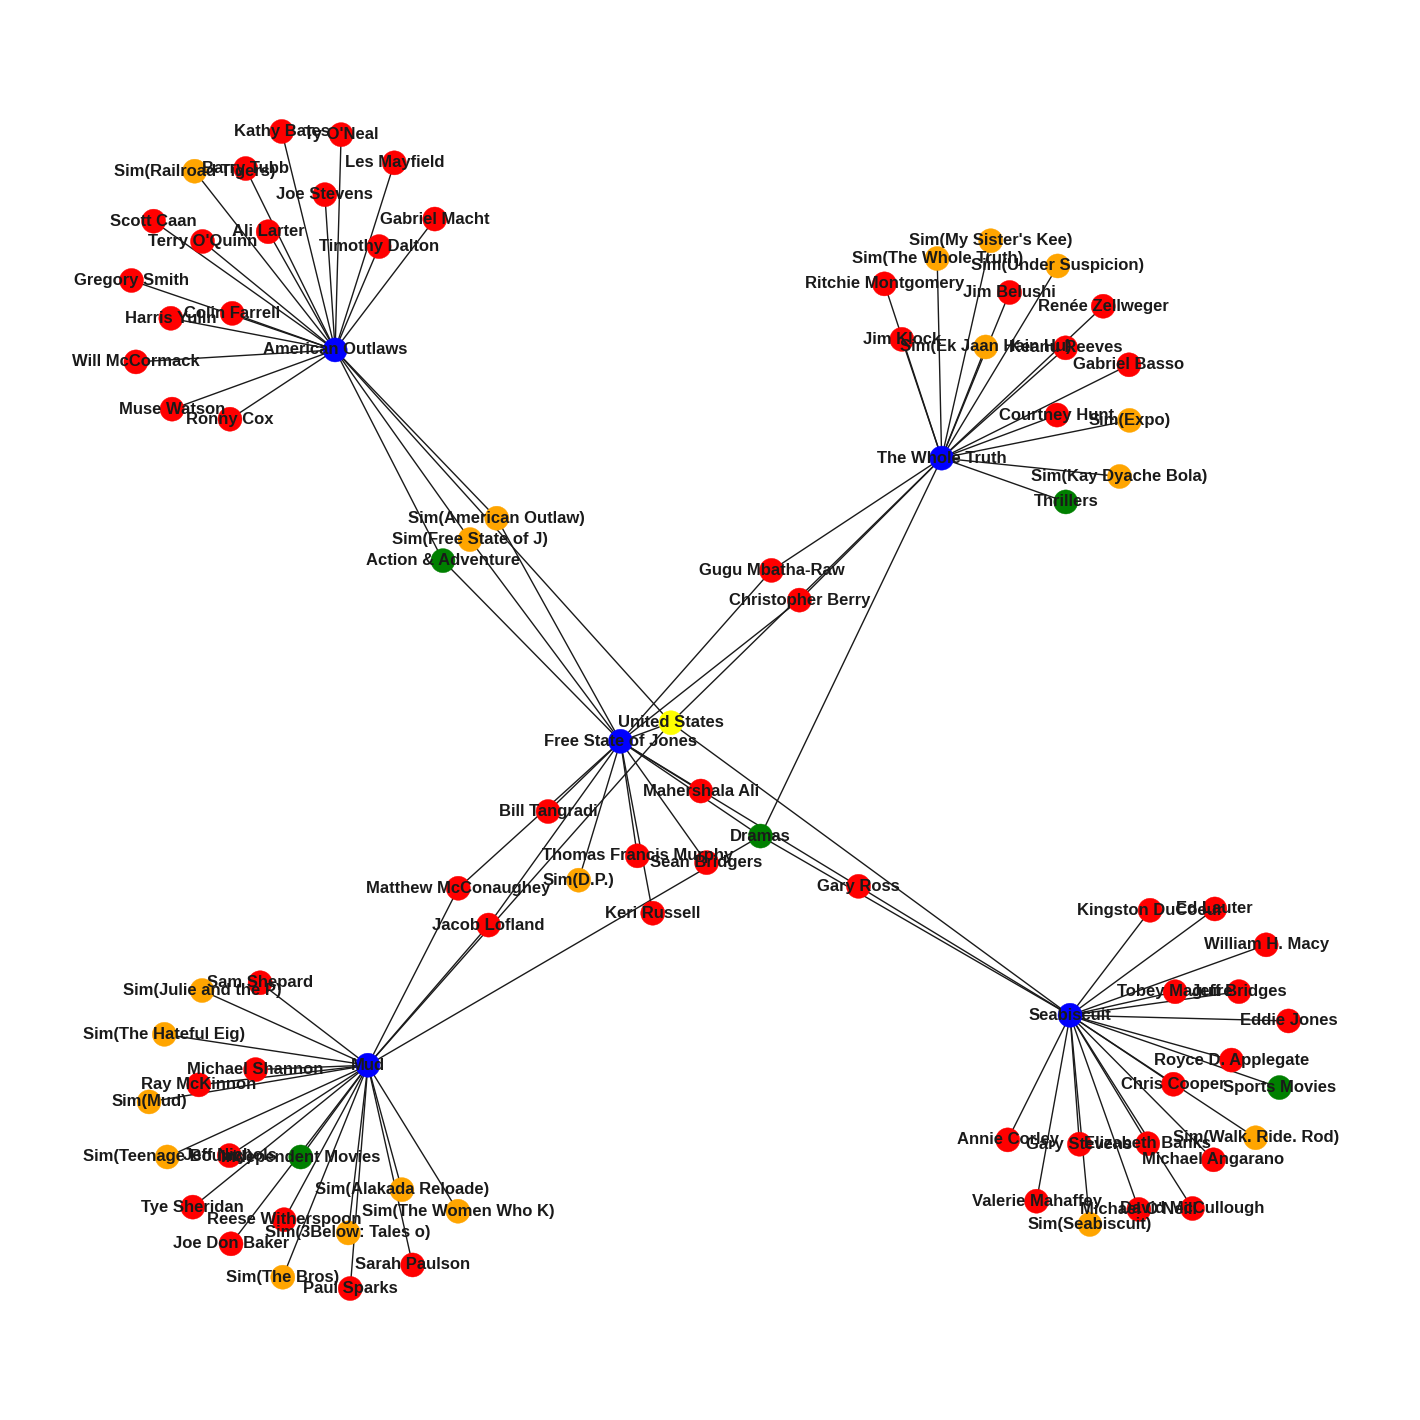

In [101]:
reco=list(result.index[:4].values)
reco.extend(["Free State of Jones"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)
